# Experiment 3: Generate WikiArt Images for Evaluation

This notebook generates bulk WikiArt images for quantitative evaluation:
- 100 images per art style × 27 styles × multiple guidance scales
- Images saved in organized directory structure
- Also exports real WikiArt images for FID comparison

**Output Structure:**
```
outputs/experiment_3/
├── dataset/
│   └── style_0_Abstract_Expressionism/
│   └── style_1_Action_painting/
│   └── ... (27 styles)
├── generated/
│   └── guidance_0/
│       └── style_0_Abstract_Expressionism/
│       └── ... (27 styles)
│   └── guidance_5/
│   └── ... (9 guidance scales)
└── metrics/
```

## 1. Setup and Configuration

In [1]:
# Project configuration - use absolute paths
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/doshlom4/work/final_project


In [2]:
# Import configuration
from config import (
    EXPERIMENT_3_CONFIG,
    INFERENCE_CONFIG,
    TOKENIZER_MAX_LENGTH,
    CLIP_MODEL_NAME,
    WIKIART_STYLES,
    DATASET_CACHE_DIR,
    EXPERIMENT_3_DIR,
    EXPERIMENT_3_DATASET_DIR,
    EXPERIMENT_3_GENERATED_DIR,
    get_latest_wikiart_unet_checkpoint,
    get_wikiart_generated_images_dir,
    get_style_dir,
    ensure_experiment_3_dirs,
)

# Deep learning frameworks
import torch
from diffusers import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm

# Standard libraries
import numpy as np
from PIL import Image
import os

# HuggingFace datasets
from datasets import load_dataset
import torchvision.transforms as transforms

print("Libraries imported successfully")

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# Generation configuration
IMAGES_PER_STYLE = 50  # Reduced from 100 to 50
GUIDANCE_SCALES = EXPERIMENT_3_CONFIG["guidance_scales"]  # [0, 5, 10, 15, 20, 30, 40, 50, 100]
NUM_INFERENCE_STEPS = INFERENCE_CONFIG["num_inference_steps"]  # 50

# Smaller batch size for 128x128 images (memory constraints)
GENERATION_BATCH_SIZE = 4

print("Generation Configuration:")
print(f"  Images per style: {IMAGES_PER_STYLE}")
print(f"  Number of styles: {len(WIKIART_STYLES)}")
print(f"  Guidance scales: {GUIDANCE_SCALES}")
print(f"  Inference steps: {NUM_INFERENCE_STEPS}")
print(f"  Batch size: {GENERATION_BATCH_SIZE}")
print()
total_images = IMAGES_PER_STYLE * len(WIKIART_STYLES) * len(GUIDANCE_SCALES)
print(f"Total images to generate: {total_images:,}")


Generation Configuration:
  Images per style: 50
  Number of styles: 27
  Guidance scales: [0, 1, 2, 3, 4, 5, 10, 20, 50]
  Inference steps: 50
  Batch size: 4

Total images to generate: 12,150


In [4]:
# Create directory structure
ensure_experiment_3_dirs()
print(f"Output directories created under: {EXPERIMENT_3_DIR}")

Output directories created under: /home/doshlom4/work/final_project/outputs/experiment_3


In [5]:
# Check what's already been generated
print("Checking existing images...\n")

# Check real dataset images
real_image_count = 0
real_per_style = {}
for style_idx in range(len(WIKIART_STYLES)):
    style_dir = get_style_dir(EXPERIMENT_3_DATASET_DIR, style_idx)
    if style_dir.exists():
        count = len(list(style_dir.glob("*.png")))
        real_per_style[style_idx] = count
        real_image_count += count
    else:
        real_per_style[style_idx] = 0

expected_real = IMAGES_PER_STYLE * len(WIKIART_STYLES)
print(f"Real dataset images: {real_image_count}/{expected_real}")
if real_image_count >= expected_real:
    print("  ✓ Real images already exported")
else:
    print(f"  → Need to export {expected_real - real_image_count} more real images")

# Check generated images per guidance scale
print("\nGenerated images per guidance scale:")
for guidance_scale in GUIDANCE_SCALES:
    guidance_dir = get_wikiart_generated_images_dir(guidance_scale)
    total = 0
    
    if guidance_dir.exists():
        for style_idx in range(len(WIKIART_STYLES)):
            style_dir = get_style_dir(guidance_dir, style_idx)
            if style_dir.exists():
                total += len(list(style_dir.glob("*.png")))
    
    expected = IMAGES_PER_STYLE * len(WIKIART_STYLES)
    status = "✓" if total >= expected else f"→ Need {expected - total} more"
    print(f"  Guidance {guidance_scale:3d}: {total:5d}/{expected} images {status}")


Checking existing images...

Real dataset images: 623/1350
  → Need to export 727 more real images

Generated images per guidance scale:
  Guidance   0:     0/1350 images → Need 1350 more
  Guidance   1:     0/1350 images → Need 1350 more
  Guidance   2:     0/1350 images → Need 1350 more
  Guidance   3:     0/1350 images → Need 1350 more
  Guidance   4:     0/1350 images → Need 1350 more
  Guidance   5:     0/1350 images → Need 1350 more
  Guidance  10:     0/1350 images → Need 1350 more
  Guidance  20:     0/1350 images → Need 1350 more
  Guidance  50:     0/1350 images → Need 1350 more


## 2. Load Models

In [6]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100 80GB PCIe
Memory: 85.09 GB


In [7]:
# Load trained UNet model
from models.custom_unet_wikiart import load_wikiart_unet_from_checkpoint

checkpoint_path = get_latest_wikiart_unet_checkpoint()
print(f"Loading checkpoint: {checkpoint_path}")

unet, checkpoint = load_wikiart_unet_from_checkpoint(str(checkpoint_path), device)
unet.eval()

# Extract epoch from filename
try:
    epoch = int(str(checkpoint_path).split("_")[-1].split(".")[0])
    print(f"\n✓ Loaded WikiArt UNet from epoch {epoch}")
except (ValueError, IndexError):
    print(f"\n✓ Loaded WikiArt UNet from checkpoint")


Loading checkpoint: /home/doshlom4/work/final_project/checkpoints/wikiart_unet_checkpoint_epoch_99.pt
Loaded WikiArt UNet from checkpoint

✓ Loaded WikiArt UNet from epoch 99


In [8]:
# Load CLIP text encoder and tokenizer
text_encoder = CLIPTextModel.from_pretrained(CLIP_MODEL_NAME).to(device)
tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL_NAME)

text_encoder.eval()
text_encoder.requires_grad_(False)

print(f"✓ Loaded CLIP text encoder: {CLIP_MODEL_NAME}")

✓ Loaded CLIP text encoder: openai/clip-vit-base-patch32


## 3. Generation Function

In [9]:
@torch.no_grad()
def generate_batch(
    prompts: list[str],
    guidance_scale: float,
    num_inference_steps: int = 50
) -> list[Image.Image]:
    """
    Generate a batch of WikiArt images.
    
    Args:
        prompts: List of text prompts
        guidance_scale: CFG scale
        num_inference_steps: Number of denoising steps
    
    Returns:
        List of PIL Images
    """
    batch_size = len(prompts)
    
    # Encode text prompts
    text_input = tokenizer(
        prompts,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        truncation=True,
        return_tensors="pt"
    )
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    
    # Unconditional embeddings for CFG
    uncond_input = tokenizer(
        [""] * batch_size,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    
    # Concatenate for CFG
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Initialize noise
    latents = torch.randn((batch_size, 3, 128, 128), device=device)
    
    # Setup scheduler
    scheduler = DDPMScheduler(
        beta_schedule=INFERENCE_CONFIG["beta_schedule"],
        num_train_timesteps=INFERENCE_CONFIG["num_train_timesteps"]
    )
    scheduler.set_timesteps(num_inference_steps)
    
    # Denoising loop
    for t in scheduler.timesteps:
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        
        # CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Convert to PIL images
    images = (latents / 2 + 0.5).clamp(0, 1)
    images = images.cpu().numpy()
    
    pil_images = []
    for img in images:
        img = (np.transpose(img, (1, 2, 0)) * 255).astype(np.uint8)
        pil_images.append(Image.fromarray(img))
    
    return pil_images


print("Generation function defined")

Generation function defined


## 4. Export Real WikiArt Images

Export real WikiArt images for FID comparison.

In [10]:
# Load WikiArt dataset
print("Loading WikiArt dataset...")
wikiart_hf = load_dataset(
    "huggan/wikiart",
    split="train",
    cache_dir=str(DATASET_CACHE_DIR / "huggingface")
)

print(f"Loaded {len(wikiart_hf)} images")

# Detect style column
sample = wikiart_hf[0]
style_column = 'style' if 'style' in sample else 'label'
print(f"Style column: {style_column}")

Loading WikiArt dataset...
Loaded 81444 images
Style column: style


In [11]:
# Check if we need to export real images
real_images_needed = False
for style_idx in range(len(WIKIART_STYLES)):
    style_dir = get_style_dir(EXPERIMENT_3_DATASET_DIR, style_idx)
    if style_dir.exists():
        count = len(list(style_dir.glob("*.png")))
        if count < IMAGES_PER_STYLE:
            real_images_needed = True
            break
    else:
        real_images_needed = True
        break

if not real_images_needed:
    print("✓ All real images already exported. Skipping export step.")
else:
    print(f"→ Proceeding with real image export...")


→ Proceeding with real image export...


In [12]:
# Export real images only if needed
if real_images_needed:
    print(f"\nExporting {IMAGES_PER_STYLE} real images per style to {EXPERIMENT_3_DATASET_DIR}")
    
    # Track how many we've saved per style
    saved_per_style = {i: 0 for i in range(len(WIKIART_STYLES))}
    
    # Check existing images first
    for style_idx in range(len(WIKIART_STYLES)):
        style_dir = get_style_dir(EXPERIMENT_3_DATASET_DIR, style_idx)
        if style_dir.exists():
            saved_per_style[style_idx] = len(list(style_dir.glob("*.png")))
    
    # Only export if we need more images
    if not all(count >= IMAGES_PER_STYLE for count in saved_per_style.values()):
        for item in tqdm(wikiart_hf, desc="Exporting real images"):
            style_idx = item[style_column]
            
            # Skip if style index is out of range or we have enough
            if style_idx >= len(WIKIART_STYLES):
                continue
            if saved_per_style[style_idx] >= IMAGES_PER_STYLE:
                continue
            
            # Get image and resize to 128x128
            image = item['image']
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image = image.resize((128, 128), Image.LANCZOS)
            
            # Save image
            style_dir = get_style_dir(EXPERIMENT_3_DATASET_DIR, style_idx)
            style_dir.mkdir(parents=True, exist_ok=True)
            
            image_path = style_dir / f"real_{saved_per_style[style_idx]:04d}.png"
            image.save(image_path)
            
            saved_per_style[style_idx] += 1
            
            # Check if we have enough for all styles
            if all(count >= IMAGES_PER_STYLE for count in saved_per_style.values()):
                break
    
    print("\nExport complete!")
    for style_idx, count in saved_per_style.items():
        status = "✓" if count >= IMAGES_PER_STYLE else f"✗ (only {count})"
        print(f"  {WIKIART_STYLES[style_idx]}: {count} images {status}")
else:
    print("Skipping real image export (already complete)")



Exporting 50 real images per style to /home/doshlom4/work/final_project/outputs/experiment_3/dataset


Exporting real images:  51%|█████▏    | 41922/81444 [26:02<24:33, 26.83it/s]  


Export complete!
  Abstract_Expressionism: 50 images ✓
  Action_painting: 50 images ✓
  Analytical_Cubism: 50 images ✓
  Art_Nouveau_Modern: 50 images ✓
  Baroque: 50 images ✓
  Color_Field_Painting: 50 images ✓
  Contemporary_Realism: 50 images ✓
  Cubism: 50 images ✓
  Early_Renaissance: 50 images ✓
  Expressionism: 50 images ✓
  Fauvism: 50 images ✓
  High_Renaissance: 50 images ✓
  Impressionism: 50 images ✓
  Mannerism_Late_Renaissance: 50 images ✓
  Minimalism: 50 images ✓
  Naive_Art_Primitivism: 50 images ✓
  New_Realism: 50 images ✓
  Northern_Renaissance: 50 images ✓
  Pointillism: 50 images ✓
  Pop_Art: 50 images ✓
  Post_Impressionism: 50 images ✓
  Realism: 50 images ✓
  Rococo: 50 images ✓
  Romanticism: 50 images ✓
  Symbolism: 50 images ✓
  Synthetic_Cubism: 50 images ✓
  Ukiyo_e: 50 images ✓


## 5. Generate Images for All Guidance Scales

In [13]:
# Main generation loop
print(f"\n{'='*70}")
print(f"Starting WikiArt Image Generation")
print(f"{'='*70}")
print(f"Styles: {len(WIKIART_STYLES)}")
print(f"Images per style: {IMAGES_PER_STYLE}")
print(f"Guidance scales: {GUIDANCE_SCALES}")
print(f"Batch size: {GENERATION_BATCH_SIZE}")
print(f"{'='*70}\n")

total_generated = 0

for guidance_scale in GUIDANCE_SCALES:
    print(f"\n=== Guidance Scale: {guidance_scale} ===")
    
    # Check if this guidance scale is already complete
    guidance_dir = get_wikiart_generated_images_dir(guidance_scale)
    guidance_total = 0
    if guidance_dir.exists():
        for s_idx in range(len(WIKIART_STYLES)):
            s_dir = get_style_dir(guidance_dir, s_idx)
            if s_dir.exists():
                guidance_total += len(list(s_dir.glob("*.png")))
    
    expected_total = IMAGES_PER_STYLE * len(WIKIART_STYLES)
    if guidance_total >= expected_total:
        print(f"✓ Already complete ({guidance_total}/{expected_total} images)")
        continue
    
    # Generate images for each style
    for style_idx, style_name in enumerate(WIKIART_STYLES):
        style_display = style_name.replace('_', ' ')
        prompt = EXPERIMENT_3_CONFIG["prompt_template"].format(style_name=style_display)
        
        # Get output directory
        style_dir = get_style_dir(guidance_dir, style_idx)
        style_dir.mkdir(parents=True, exist_ok=True)
        
        # Check how many already exist for this style
        existing = len(list(style_dir.glob("*.png")))
        
        # Skip if we already have enough images for this style
        if existing >= IMAGES_PER_STYLE:
            continue
        
        # Calculate how many more images we need (NOT how many total)
        remaining = IMAGES_PER_STYLE - existing
        num_batches = (remaining + GENERATION_BATCH_SIZE - 1) // GENERATION_BATCH_SIZE
        
        # Start counting from existing number
        generated_count = existing
        
        # Generate only the remaining images
        for batch_idx in tqdm(range(num_batches), 
                               desc=f"  [{style_idx+1:2d}/{len(WIKIART_STYLES)}] {style_display} ({existing}→{IMAGES_PER_STYLE})", 
                               leave=False):
            # Calculate batch size (might be smaller for last batch)
            batch_size = min(GENERATION_BATCH_SIZE, IMAGES_PER_STYLE - generated_count)
            prompts = [prompt] * batch_size
            
            # Generate batch
            images = generate_batch(prompts, guidance_scale, NUM_INFERENCE_STEPS)
            
            # Save images with correct numbering
            for img in images:
                image_path = style_dir / f"gen_{generated_count:04d}.png"
                img.save(image_path)
                generated_count += 1
                total_generated += 1
        
        print(f"  [{style_idx+1:2d}/{len(WIKIART_STYLES)}] {style_display}: {generated_count}/{IMAGES_PER_STYLE} images (generated {generated_count - existing} new)")

print(f"\n{'='*70}")
print(f"Generation Complete!")
print(f"{'='*70}")
print(f"Total new images generated: {total_generated:,}")



Starting WikiArt Image Generation
Styles: 27
Images per style: 50
Guidance scales: [0, 1, 2, 3, 4, 5, 10, 20, 50]
Batch size: 4


=== Guidance Scale: 0 ===


  [ 1/27] Abstract Expressionism: 50/50 images (generated 50 new)


  [ 2/27] Action painting: 50/50 images (generated 50 new)


  [ 3/27] Analytical Cubism: 50/50 images (generated 50 new)


  [ 4/27] Art Nouveau Modern: 50/50 images (generated 50 new)


  [ 5/27] Baroque: 50/50 images (generated 50 new)


  [ 6/27] Color Field Painting: 50/50 images (generated 50 new)


  [ 7/27] Contemporary Realism: 50/50 images (generated 50 new)


  [ 8/27] Cubism: 50/50 images (generated 50 new)


  [ 9/27] Early Renaissance: 50/50 images (generated 50 new)


  [10/27] Expressionism: 50/50 images (generated 50 new)


  [11/27] Fauvism: 50/50 images (generated 50 new)


  [12/27] High Renaissance: 50/50 images (generated 50 new)


  [13/27] Impressionism: 50/50 images (generated 50 new)


  [14/27] Mannerism Late Renaissance: 50/50 images (generated 50 new)


  [15/27] Minimalism: 50/50 images (generated 50 new)


  [16/27] Naive Art Primitivism: 50/50 images (generated 50 new)


  [17/27] New Realism: 50/50 images (generated 50 new)


  [18/27] Northern Renaissance: 50/50 images (generated 50 new)


  [19/27] Pointillism: 50/50 images (generated 50 new)


  [20/27] Pop Art: 50/50 images (generated 50 new)


  [21/27] Post Impressionism: 50/50 images (generated 50 new)


  [22/27] Realism: 50/50 images (generated 50 new)


  [23/27] Rococo: 50/50 images (generated 50 new)


  [24/27] Romanticism: 50/50 images (generated 50 new)


  [25/27] Symbolism: 50/50 images (generated 50 new)


  [26/27] Synthetic Cubism: 50/50 images (generated 50 new)


  [27/27] Ukiyo e: 50/50 images (generated 50 new)

=== Guidance Scale: 1 ===


  [ 1/27] Abstract Expressionism: 50/50 images (generated 50 new)


  [ 2/27] Action painting: 50/50 images (generated 50 new)


  [ 3/27] Analytical Cubism: 50/50 images (generated 50 new)


  [ 4/27] Art Nouveau Modern: 50/50 images (generated 50 new)


  [ 5/27] Baroque: 50/50 images (generated 50 new)


  [ 6/27] Color Field Painting: 50/50 images (generated 50 new)


  [ 7/27] Contemporary Realism: 50/50 images (generated 50 new)


  [ 8/27] Cubism: 50/50 images (generated 50 new)


  [ 9/27] Early Renaissance: 50/50 images (generated 50 new)


  [10/27] Expressionism: 50/50 images (generated 50 new)


  [11/27] Fauvism: 50/50 images (generated 50 new)


  [12/27] High Renaissance: 50/50 images (generated 50 new)


  [13/27] Impressionism: 50/50 images (generated 50 new)


  [14/27] Mannerism Late Renaissance: 50/50 images (generated 50 new)


  [15/27] Minimalism: 50/50 images (generated 50 new)


  [16/27] Naive Art Primitivism: 50/50 images (generated 50 new)


  [17/27] New Realism: 50/50 images (generated 50 new)


  [18/27] Northern Renaissance: 50/50 images (generated 50 new)


  [19/27] Pointillism: 50/50 images (generated 50 new)


  [20/27] Pop Art: 50/50 images (generated 50 new)


  [21/27] Post Impressionism: 50/50 images (generated 50 new)


  [22/27] Realism: 50/50 images (generated 50 new)


  [23/27] Rococo: 50/50 images (generated 50 new)


  [24/27] Romanticism: 50/50 images (generated 50 new)


  [25/27] Symbolism: 50/50 images (generated 50 new)


  [26/27] Synthetic Cubism: 50/50 images (generated 50 new)


  [27/27] Ukiyo e: 50/50 images (generated 50 new)

=== Guidance Scale: 2 ===


  [ 1/27] Abstract Expressionism: 50/50 images (generated 50 new)


  [ 2/27] Action painting: 50/50 images (generated 50 new)


  [ 3/27] Analytical Cubism: 50/50 images (generated 50 new)


  [ 4/27] Art Nouveau Modern: 50/50 images (generated 50 new)


  [ 5/27] Baroque: 50/50 images (generated 50 new)


  [ 6/27] Color Field Painting: 50/50 images (generated 50 new)


  [ 7/27] Contemporary Realism: 50/50 images (generated 50 new)


  [ 8/27] Cubism: 50/50 images (generated 50 new)


  [ 9/27] Early Renaissance: 50/50 images (generated 50 new)


  [10/27] Expressionism: 50/50 images (generated 50 new)


  [11/27] Fauvism: 50/50 images (generated 50 new)


  [12/27] High Renaissance: 50/50 images (generated 50 new)


  [13/27] Impressionism: 50/50 images (generated 50 new)


  [14/27] Mannerism Late Renaissance: 50/50 images (generated 50 new)


  [15/27] Minimalism: 50/50 images (generated 50 new)


  [16/27] Naive Art Primitivism: 50/50 images (generated 50 new)


  [17/27] New Realism: 50/50 images (generated 50 new)


  [18/27] Northern Renaissance: 50/50 images (generated 50 new)


  [19/27] Pointillism: 50/50 images (generated 50 new)


  [20/27] Pop Art: 50/50 images (generated 50 new)


  [21/27] Post Impressionism: 50/50 images (generated 50 new)


  [22/27] Realism: 50/50 images (generated 50 new)


  [23/27] Rococo: 50/50 images (generated 50 new)


  [24/27] Romanticism: 50/50 images (generated 50 new)


  [25/27] Symbolism: 50/50 images (generated 50 new)


  [26/27] Synthetic Cubism: 50/50 images (generated 50 new)


  [27/27] Ukiyo e: 50/50 images (generated 50 new)

=== Guidance Scale: 3 ===


  [ 1/27] Abstract Expressionism: 50/50 images (generated 50 new)


  [ 2/27] Action painting: 50/50 images (generated 50 new)


  [ 3/27] Analytical Cubism: 50/50 images (generated 50 new)


  [ 4/27] Art Nouveau Modern: 50/50 images (generated 50 new)


  [ 5/27] Baroque: 50/50 images (generated 50 new)


  [ 6/27] Color Field Painting: 50/50 images (generated 50 new)


  [ 7/27] Contemporary Realism: 50/50 images (generated 50 new)


  [ 8/27] Cubism: 50/50 images (generated 50 new)


  [ 9/27] Early Renaissance: 50/50 images (generated 50 new)


  [10/27] Expressionism: 50/50 images (generated 50 new)


  [11/27] Fauvism: 50/50 images (generated 50 new)


  [12/27] High Renaissance: 50/50 images (generated 50 new)


  [13/27] Impressionism: 50/50 images (generated 50 new)


  [14/27] Mannerism Late Renaissance: 50/50 images (generated 50 new)


  [15/27] Minimalism: 50/50 images (generated 50 new)


  [16/27] Naive Art Primitivism: 50/50 images (generated 50 new)


  [17/27] New Realism: 50/50 images (generated 50 new)


  [18/27] Northern Renaissance: 50/50 images (generated 50 new)


  [19/27] Pointillism: 50/50 images (generated 50 new)


  [20/27] Pop Art: 50/50 images (generated 50 new)


  [21/27] Post Impressionism: 50/50 images (generated 50 new)


  [22/27] Realism: 50/50 images (generated 50 new)


  [23/27] Rococo: 50/50 images (generated 50 new)


  [24/27] Romanticism: 50/50 images (generated 50 new)


  [25/27] Symbolism: 50/50 images (generated 50 new)


  [26/27] Synthetic Cubism: 50/50 images (generated 50 new)


  [27/27] Ukiyo e: 50/50 images (generated 50 new)

=== Guidance Scale: 4 ===


  [ 1/27] Abstract Expressionism: 50/50 images (generated 50 new)


  [ 2/27] Action painting: 50/50 images (generated 50 new)


  [ 3/27] Analytical Cubism: 50/50 images (generated 50 new)


  [ 4/27] Art Nouveau Modern: 50/50 images (generated 50 new)


  [ 5/27] Baroque: 50/50 images (generated 50 new)


  [ 6/27] Color Field Painting: 50/50 images (generated 50 new)


  [ 7/27] Contemporary Realism: 50/50 images (generated 50 new)


  [ 8/27] Cubism: 50/50 images (generated 50 new)


  [ 9/27] Early Renaissance: 50/50 images (generated 50 new)


  [10/27] Expressionism: 50/50 images (generated 50 new)


  [11/27] Fauvism: 50/50 images (generated 50 new)


  [12/27] High Renaissance: 50/50 images (generated 50 new)


  [13/27] Impressionism: 50/50 images (generated 50 new)


  [14/27] Mannerism Late Renaissance: 50/50 images (generated 50 new)


  [15/27] Minimalism: 50/50 images (generated 50 new)


  [16/27] Naive Art Primitivism: 50/50 images (generated 50 new)


  [17/27] New Realism: 50/50 images (generated 50 new)


  [18/27] Northern Renaissance: 50/50 images (generated 50 new)


  [19/27] Pointillism: 50/50 images (generated 50 new)


  [20/27] Pop Art: 50/50 images (generated 50 new)


  [21/27] Post Impressionism: 50/50 images (generated 50 new)


  [22/27] Realism: 50/50 images (generated 50 new)


  [23/27] Rococo: 50/50 images (generated 50 new)


  [24/27] Romanticism: 50/50 images (generated 50 new)


  [25/27] Symbolism: 50/50 images (generated 50 new)


  [26/27] Synthetic Cubism: 50/50 images (generated 50 new)


  [27/27] Ukiyo e: 50/50 images (generated 50 new)

=== Guidance Scale: 5 ===


  [ 1/27] Abstract Expressionism: 50/50 images (generated 50 new)


  [ 2/27] Action painting: 50/50 images (generated 50 new)


  [ 3/27] Analytical Cubism: 50/50 images (generated 50 new)


  [ 4/27] Art Nouveau Modern: 50/50 images (generated 50 new)


  [ 5/27] Baroque: 50/50 images (generated 50 new)


  [ 6/27] Color Field Painting: 50/50 images (generated 50 new)


  [ 7/27] Contemporary Realism: 50/50 images (generated 50 new)


  [ 8/27] Cubism: 50/50 images (generated 50 new)


  [ 9/27] Early Renaissance: 50/50 images (generated 50 new)


  [10/27] Expressionism: 50/50 images (generated 50 new)


  [11/27] Fauvism: 50/50 images (generated 50 new)


  [12/27] High Renaissance: 50/50 images (generated 50 new)


  [13/27] Impressionism: 50/50 images (generated 50 new)


  [14/27] Mannerism Late Renaissance: 50/50 images (generated 50 new)


  [15/27] Minimalism: 50/50 images (generated 50 new)


  [16/27] Naive Art Primitivism: 50/50 images (generated 50 new)


  [17/27] New Realism: 50/50 images (generated 50 new)


  [18/27] Northern Renaissance: 50/50 images (generated 50 new)


  [19/27] Pointillism: 50/50 images (generated 50 new)


  [20/27] Pop Art: 50/50 images (generated 50 new)


  [21/27] Post Impressionism: 50/50 images (generated 50 new)


  [22/27] Realism: 50/50 images (generated 50 new)


  [23/27] Rococo: 50/50 images (generated 50 new)


  [24/27] Romanticism: 50/50 images (generated 50 new)


  [25/27] Symbolism: 50/50 images (generated 50 new)


  [26/27] Synthetic Cubism: 50/50 images (generated 50 new)


  [27/27] Ukiyo e: 50/50 images (generated 50 new)

=== Guidance Scale: 10 ===


  [ 1/27] Abstract Expressionism: 50/50 images (generated 50 new)


  [ 2/27] Action painting: 50/50 images (generated 50 new)


  [ 3/27] Analytical Cubism: 50/50 images (generated 50 new)


  [ 4/27] Art Nouveau Modern: 50/50 images (generated 50 new)


  [ 5/27] Baroque: 50/50 images (generated 50 new)


  [ 6/27] Color Field Painting: 50/50 images (generated 50 new)


  [ 7/27] Contemporary Realism: 50/50 images (generated 50 new)


  [ 8/27] Cubism: 50/50 images (generated 50 new)


  [ 9/27] Early Renaissance: 50/50 images (generated 50 new)


  [10/27] Expressionism: 50/50 images (generated 50 new)


  [11/27] Fauvism: 50/50 images (generated 50 new)


  [12/27] High Renaissance: 50/50 images (generated 50 new)


  [13/27] Impressionism: 50/50 images (generated 50 new)


  [14/27] Mannerism Late Renaissance: 50/50 images (generated 50 new)


  [15/27] Minimalism: 50/50 images (generated 50 new)


  [16/27] Naive Art Primitivism: 50/50 images (generated 50 new)


  [17/27] New Realism: 50/50 images (generated 50 new)


  [18/27] Northern Renaissance: 50/50 images (generated 50 new)


  [19/27] Pointillism: 50/50 images (generated 50 new)


  [20/27] Pop Art: 50/50 images (generated 50 new)


  [21/27] Post Impressionism: 50/50 images (generated 50 new)


  [22/27] Realism: 50/50 images (generated 50 new)


  [23/27] Rococo: 50/50 images (generated 50 new)


  [24/27] Romanticism: 50/50 images (generated 50 new)


  [25/27] Symbolism: 50/50 images (generated 50 new)


  [26/27] Synthetic Cubism: 50/50 images (generated 50 new)


  [27/27] Ukiyo e: 50/50 images (generated 50 new)

=== Guidance Scale: 20 ===


  [ 1/27] Abstract Expressionism: 50/50 images (generated 50 new)


  [ 2/27] Action painting: 50/50 images (generated 50 new)


  [ 3/27] Analytical Cubism: 50/50 images (generated 50 new)


  [ 4/27] Art Nouveau Modern: 50/50 images (generated 50 new)


  [ 5/27] Baroque: 50/50 images (generated 50 new)


  [ 6/27] Color Field Painting: 50/50 images (generated 50 new)


  [ 7/27] Contemporary Realism: 50/50 images (generated 50 new)


  [ 8/27] Cubism: 50/50 images (generated 50 new)


  [ 9/27] Early Renaissance: 50/50 images (generated 50 new)


  [10/27] Expressionism: 50/50 images (generated 50 new)


  [11/27] Fauvism: 50/50 images (generated 50 new)


  [12/27] High Renaissance: 50/50 images (generated 50 new)


  [13/27] Impressionism: 50/50 images (generated 50 new)


  [14/27] Mannerism Late Renaissance: 50/50 images (generated 50 new)


  [15/27] Minimalism: 50/50 images (generated 50 new)


  [16/27] Naive Art Primitivism: 50/50 images (generated 50 new)


  [17/27] New Realism: 50/50 images (generated 50 new)


  [18/27] Northern Renaissance: 50/50 images (generated 50 new)


  [19/27] Pointillism: 50/50 images (generated 50 new)


  [20/27] Pop Art: 50/50 images (generated 50 new)


  [21/27] Post Impressionism: 50/50 images (generated 50 new)


  [22/27] Realism: 50/50 images (generated 50 new)


  [23/27] Rococo: 50/50 images (generated 50 new)


  [24/27] Romanticism: 50/50 images (generated 50 new)


  [25/27] Symbolism: 50/50 images (generated 50 new)


  [26/27] Synthetic Cubism: 50/50 images (generated 50 new)


  [27/27] Ukiyo e: 50/50 images (generated 50 new)

=== Guidance Scale: 50 ===


  [ 1/27] Abstract Expressionism: 50/50 images (generated 50 new)


  [ 2/27] Action painting: 50/50 images (generated 50 new)


  [ 3/27] Analytical Cubism: 50/50 images (generated 50 new)


  [ 4/27] Art Nouveau Modern: 50/50 images (generated 50 new)


  [ 5/27] Baroque: 50/50 images (generated 50 new)


  [ 6/27] Color Field Painting: 50/50 images (generated 50 new)


  [ 7/27] Contemporary Realism: 50/50 images (generated 50 new)


  [ 8/27] Cubism: 50/50 images (generated 50 new)


  [ 9/27] Early Renaissance: 50/50 images (generated 50 new)


  [10/27] Expressionism: 50/50 images (generated 50 new)


  [11/27] Fauvism: 50/50 images (generated 50 new)


  [12/27] High Renaissance: 50/50 images (generated 50 new)


  [13/27] Impressionism: 50/50 images (generated 50 new)


  [14/27] Mannerism Late Renaissance: 50/50 images (generated 50 new)


  [15/27] Minimalism: 50/50 images (generated 50 new)


  [16/27] Naive Art Primitivism: 50/50 images (generated 50 new)


  [17/27] New Realism: 50/50 images (generated 50 new)


  [18/27] Northern Renaissance: 50/50 images (generated 50 new)


  [19/27] Pointillism: 50/50 images (generated 50 new)


  [20/27] Pop Art: 50/50 images (generated 50 new)


  [21/27] Post Impressionism: 50/50 images (generated 50 new)


  [22/27] Realism: 50/50 images (generated 50 new)


  [23/27] Rococo: 50/50 images (generated 50 new)


  [24/27] Romanticism: 50/50 images (generated 50 new)


  [25/27] Symbolism: 50/50 images (generated 50 new)


  [26/27] Synthetic Cubism: 50/50 images (generated 50 new)


  [27/27] Ukiyo e: 50/50 images (generated 50 new)

Generation Complete!
Total new images generated: 12,150


## 6. Verify Generated Images

In [14]:
# Verify image counts
print("Verification: Image counts per guidance scale\n")

for guidance_scale in GUIDANCE_SCALES:
    guidance_dir = get_wikiart_generated_images_dir(guidance_scale)
    total = 0
    style_counts = {}
    
    for style_idx in range(len(WIKIART_STYLES)):
        style_dir = get_style_dir(guidance_dir, style_idx)
        count = len(list(style_dir.glob("*.png")))
        style_counts[style_idx] = count
        total += count
    
    expected = IMAGES_PER_STYLE * len(WIKIART_STYLES)
    status = "✓" if total == expected else "✗"
    print(f"Guidance {guidance_scale:3d}: {total:5d} images (expected: {expected}) {status}")

Verification: Image counts per guidance scale

Guidance   0:  1350 images (expected: 1350) ✓
Guidance   1:  1350 images (expected: 1350) ✓
Guidance   2:  1350 images (expected: 1350) ✓
Guidance   3:  1350 images (expected: 1350) ✓
Guidance   4:  1350 images (expected: 1350) ✓
Guidance   5:  1350 images (expected: 1350) ✓
Guidance  10:  1350 images (expected: 1350) ✓
Guidance  20:  1350 images (expected: 1350) ✓
Guidance  50:  1350 images (expected: 1350) ✓


In [15]:
# Verify real dataset images
print("\nReal dataset images:")
total_real = 0

for style_idx in range(len(WIKIART_STYLES)):
    style_dir = get_style_dir(EXPERIMENT_3_DATASET_DIR, style_idx)
    count = len(list(style_dir.glob("*.png")))
    total_real += count

expected_real = IMAGES_PER_STYLE * len(WIKIART_STYLES)
status = "✓" if total_real == expected_real else "✗"
print(f"Total: {total_real} images (expected: {expected_real}) {status}")


Real dataset images:
Total: 1350 images (expected: 1350) ✓


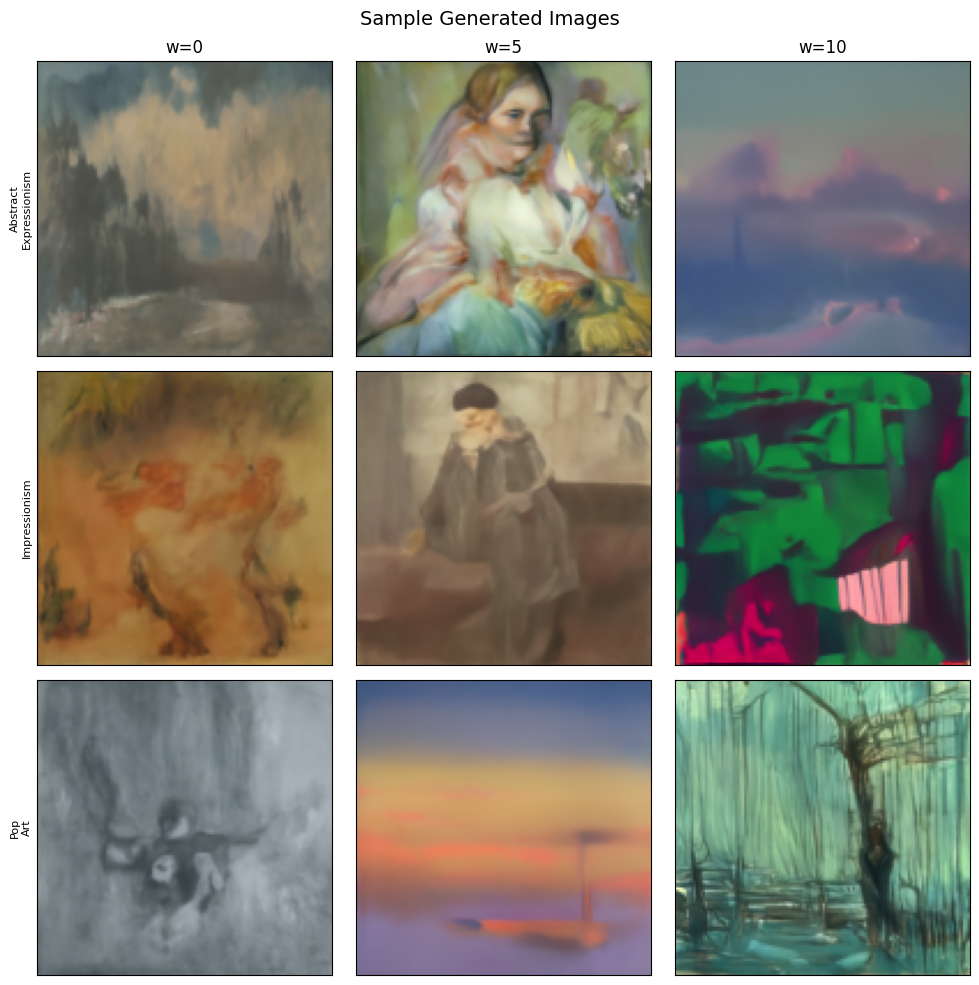

In [16]:
# Display sample generated images
import matplotlib.pyplot as plt

sample_styles = [0, 12, 19]  # Abstract_Expressionism, Impressionism, Pop_Art
sample_guidance = [0, 5, 10]

fig, axes = plt.subplots(len(sample_styles), len(sample_guidance), figsize=(10, 10))

for row, style_idx in enumerate(sample_styles):
    for col, guidance in enumerate(sample_guidance):
        guidance_dir = get_wikiart_generated_images_dir(guidance)
        style_dir = get_style_dir(guidance_dir, style_idx)
        
        # Load first image
        img_path = list(style_dir.glob("*.png"))[0]
        img = Image.open(img_path)
        
        axes[row, col].imshow(img)
        if row == 0:
            axes[row, col].set_title(f'w={guidance}')
        if col == 0:
            axes[row, col].set_ylabel(WIKIART_STYLES[style_idx].replace('_', '\n'), fontsize=8)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

plt.suptitle('Sample Generated Images', fontsize=14)
plt.tight_layout()
plt.show()

## Summary

This notebook generated bulk WikiArt images for evaluation:

**Generated:**
- 100 images × 27 styles × 9 guidance scales = 24,300 generated images
- 100 images × 27 styles = 2,700 real images for FID comparison

**Output Locations:**
- Real images: `outputs/experiment_3/dataset/`
- Generated images: `outputs/experiment_3/generated/guidance_X/`

**Next steps:**
1. `train2_train_wikiart_classifier.ipynb` - Train art style classifier
2. `metrics1_evaluate_wikiart.ipynb` - Compute FID and classification accuracy